In [1]:
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

from Bio import SeqIO
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import logomaker
import math
import pickle
import h5py
import copy
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading the data

In [2]:
num_epochs = 10
batch_size = 100 
learning_rate = 0.001 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# PMID: 32978299
x = np.load("../../AI-TAC/ai_tac_data/one_hot_seqs.npy")
x = x.astype(np.float32)
y = np.load("../../AI-TAC/ai_tac_data/cell_type_array.npy")
y = y.astype(np.float32)
peak_names = np.load("../../AI-TAC/ai_tac_data/peak_names.npy")

In [4]:
x.shape

(327927, 4, 251)

In [5]:
train_data, eval_data, train_labels, eval_labels, train_names, eval_names = train_test_split(x, y, peak_names, 
                                                                                             test_size=0.1, random_state=40)

# Data loader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False) #True

eval_dataset = torch.utils.data.TensorDataset(torch.from_numpy(eval_data), torch.from_numpy(eval_labels))
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False) #True

# Plug and Play (TL)

In [6]:
with open('../../data/JASPAR2020_CORE_vertebrates_nr_f=19_n=300_w=pfm.pkl', 'rb') as f:
    JASPAR_motifs = pickle.load(f)

len(JASPAR_motifs)

300

In [7]:
num_cnns = 300
num_classes = 81
input_length = 251

explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size=19).to(device)

# initializing with JASPAR motifs
conv_weights = explainn.linears[0].weight.data
k = 0
for motif in JASPAR_motifs.keys():
    mm = JASPAR_motifs[motif]
    conv_weights[k] = torch.tensor(np.transpose(mm))
    k += 1

conv_weights.requires_grad = True
explainn.linears[0].weight = nn.Parameter(conv_weights)

In [8]:
explainn.linears[0].weight.data[0,:,5:10]

tensor([[-0.0717, -0.2204, -0.2481,  0.2034, -0.2166],
        [-0.2286, -0.2408, -0.2444, -0.2427, -0.2100],
        [ 0.0901,  0.7079, -0.2462,  0.1482,  0.6630],
        [ 0.2103, -0.2467,  0.7387, -0.1089, -0.2364]], device='cuda:0')

In [9]:
np.transpose(JASPAR_motifs['MA1594.1;rev;ZNF382'])[:,5:10]

array([[-0.07173095, -0.22036689, -0.24811853,  0.20343368, -0.21660395],
       [-0.22859831, -0.24082785, -0.2443556 , -0.24270931, -0.21001881],
       [ 0.09007526,  0.70790216, -0.24623706,  0.14816557,  0.66298213],
       [ 0.210254  , -0.24670743,  0.73871119, -0.10888993, -0.23635936]])

In [10]:
explainn.linears[0].weight.data[-1,:,5:10]

tensor([[-0.2288,  0.7500, -0.2500, -0.2487,  0.2246],
        [-0.2500, -0.2500, -0.2500, -0.2500, -0.0897],
        [ 0.7288, -0.2500, -0.2500, -0.1744,  0.1150],
        [-0.2500, -0.2500,  0.7500,  0.6731, -0.2500]], device='cuda:0')

In [11]:
np.transpose(JASPAR_motifs['MA0468.1;rev;DUX4'])[:,5:10]

array([[-0.22883141,  0.75      , -0.25      , -0.24869168,  0.22463171],
       [-0.25      , -0.25      , -0.25      , -0.25      , -0.08967868],
       [ 0.72883141, -0.25      , -0.25      , -0.17440537,  0.11504697],
       [-0.25      , -0.25      ,  0.75      ,  0.67309705, -0.25      ]])

In [14]:
# explainn = tools.change_grad_filters(explainn, 0, list(range(300))) - freeze all filters
# explainn = tools.change_grad_filters(explainn, 0, [149,150,151])    - freeze specific filters

In [ ]:
criterion = tools.pearson_loss

learning_rate = 0.001 

optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)

os.makedirs("../CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr")

num_epochs = 10

model, train_error, test_error = train.train_explainn(train_loader, eval_loader, 
                                                      explainn, device, criterion, 
                                                      optimizer, num_epochs,
                                                      "../CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr", "", 
                                                      verbose=True, trim_weights=False)

In [12]:
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size=19).to(device)
explainn.load_state_dict(torch.load("../CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr/model_epoch_6_.pth"))
explainn.eval();

weighted_cor is 0.453053291454717
number of NaN values: 0
1630


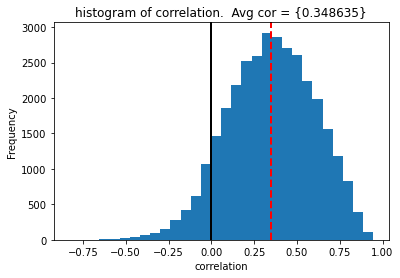

In [13]:
predictions, _ = interpretation.get_explainn_predictions(eval_loader, explainn, device)

correlations = []
vars = []
for i in range(len(predictions)):
    var = np.var(eval_labels[i, :])
    vars.append(var)
    x = np.corrcoef(predictions[i, :], eval_labels[i, :])[0, 1]
    correlations.append(x)

weighted_cor = np.dot(correlations, vars) / np.sum(vars)
print('weighted_cor is {}'.format(weighted_cor))

nan_cors = [value for value in correlations if math.isnan(value)]
print("number of NaN values: %d" % len(nan_cors))
correlations = [value for value in correlations if not math.isnan(value)]
print(np.where(np.array(correlations) >= 0.75)[0].shape[0])


%matplotlib inline
plt.clf()
plt.hist(correlations, bins=30)
plt.axvline(np.mean(correlations), color='r', linestyle='dashed', linewidth=2)
plt.axvline(0, color='k', linestyle='solid', linewidth=2)
try:
    plt.title("histogram of correlation.  Avg cor = {%f}" % np.mean(correlations))
except Exception as e:
    print("could not set the title for graph")
    print(e)
plt.ylabel("Frequency")
plt.xlabel("correlation")
#plt.savefig(output_file_path + "basset_cor_hist.svg")
plt.show() #0.3468 real CAM; 0.3411 frozen JASPAR; 0.3465 not frozen JASPAR; 0.3455 small steps

# Interpretation

In [16]:
batch_size = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = np.load("../../AI-TAC/ai_tac_data/one_hot_seqs.npy")
x = x.astype(np.float32)
y = np.load("../../AI-TAC/ai_tac_data/cell_type_array.npy")
y = y.astype(np.float32)
peak_names = np.load("../../AI-TAC/ai_tac_data/peak_names.npy")

dataset = torch.utils.data.TensorDataset(torch.from_numpy(x), torch.from_numpy(y))
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

predictions, labels = interpretation.get_explainn_predictions(data_loader, explainn, device)

correlations = []
vars = []
for i in range(len(predictions)):
    var = np.var(labels[i, :])
    vars.append(var)
    x_ = np.corrcoef(predictions[i, :], labels[i, :])[0, 1]
    correlations.append(x_)

correlations = [value for value in correlations if not math.isnan(value)]
idx = np.argwhere(np.asarray(correlations) > 0.75).squeeze()
idx.shape

(18033,)

In [ ]:
x2 = x[idx, :, :]
y2 = y[idx, :]

dataset = torch.utils.data.TensorDataset(torch.from_numpy(x2), torch.from_numpy(y2))
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
pwms = interpretation.get_pwms_explainn(activations, x, y, 19)
interpretation.pwm_to_meme("../CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr.meme")

In [ ]:
%%bash
. ~/.bashrc
./../../../meme-5.3.3/src/tomtom -oc ../../../tomtom_results/CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr ../CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr.meme ../../../tomtom_results/CisBP-mouse_NEW.meme > /dev/null 2>&1

In [20]:
tomtom_results = pd.read_csv("../../../tomtom_results/CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr/tomtom.tsv",
                                    sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../../tomtom_results/CisBP-mouse_NEW.meme") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif
            
filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann
    
filters_ind = np.array([int(i.split("filter")[-1]) for i in annotation.keys()])

annotation = pd.Series(annotation)

new_annot = {}
j_m = list(JASPAR_motifs.keys())
#for i in range(100):
for i in range(300):
    new_annot["filter"+str(i)] = 'JASPAR_'+j_m[i].split(';')[-1]
new_annot = pd.Series(new_annot)
new_annot

filter0          JASPAR_ZNF382
filter1           JASPAR_CENPB
filter2          JASPAR_ZNF382
filter3      JASPAR_EWSR1-FLI1
filter4      JASPAR_EWSR1-FLI1
                   ...        
filter295         JASPAR_VEZF1
filter296        JASPAR_HOXB13
filter297          JASPAR_SOX5
filter298          JASPAR_MTF1
filter299          JASPAR_DUX4
Length: 300, dtype: object

# Motif analysis

In [23]:
motifs, motif_names = tools.read_meme("../CAM_AITAC_PaP_300_JASPAR_300_motifs_UnFr.meme")

In [24]:
with open('../../data/JASPAR2020_CORE_vertebrates_nr_f=19_n=300_w=pfm.pkl', 'rb') as f:
    JASPAR_motifs = pickle.load(f)

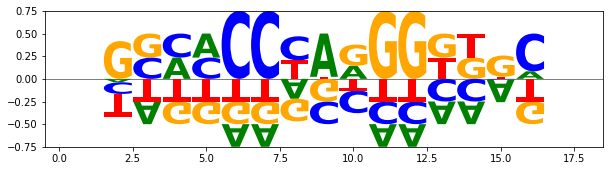

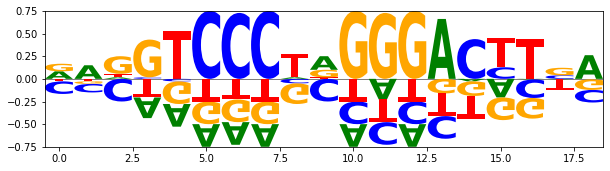

In [25]:
%matplotlib inline
import logomaker

filterid=150
nn_logo = logomaker.Logo(pd.DataFrame(data=JASPAR_motifs[list(JASPAR_motifs.keys())[filterid]],columns = ["A","C", "G","T"]))

x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, 19)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))